In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../../csv/titanic/train.csv')
test = pd.read_csv('../../csv/titanic/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [4]:
df = pd.concat(objs = [train, test], axis = 0).reset_index(drop = True)
df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

In [5]:
df['Cabin_Initial'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df['Cabin_Initial'] = df['Cabin_Initial'].replace(['A', 'B', 'C', 'T'], 'ABCT')
df['Cabin_Initial'] = df['Cabin_Initial'].replace(['D', 'E'], 'DE')
df['Cabin_Initial'] = df['Cabin_Initial'].replace(['F', 'G'], 'FG')
df['Cabin_Initial'].value_counts()

Cabin_Initial
M       1014
ABCT     182
DE        87
FG        26
Name: count, dtype: int64

In [6]:
df['Embarked'] = df['Embarked'].fillna('S')

In [7]:
df['Fare'] = df['Fare'].fillna(df.groupby(['Pclass', 'Embarked'])['Fare'].median()[3]['S'])

In [8]:
def binding_band(column, binnum):
    df[column + '_band'] = pd.qcut(df[column].map(int), binnum)
    
    for i in range(len(df[column + '_band'].value_counts().index)):
        print('{}_band {} :'.format(column, i), df[column + '_band'].value_counts().index.sort_values(ascending=True)[i])
        df[column + '_band'] = df[column + '_band'].replace(df[column + '_band'].value_counts().index.sort_values(ascending=True)[i], int(i))
    df[column + '_band'] = df[column + '_band'].astype(int)
    return df.head()

binding_band('Age', 8)
binding_band('Fare', 6)

Age_band 0 : (-0.001, 18.0]
Age_band 1 : (18.0, 22.0]
Age_band 2 : (22.0, 25.0]
Age_band 3 : (25.0, 26.0]
Age_band 4 : (26.0, 30.0]
Age_band 5 : (30.0, 36.0]
Age_band 6 : (36.0, 45.0]
Age_band 7 : (45.0, 80.0]
Fare_band 0 : (-0.001, 7.0]
Fare_band 1 : (7.0, 8.0]
Fare_band 2 : (8.0, 14.0]
Fare_band 3 : (14.0, 26.0]
Fare_band 4 : (26.0, 53.0]
Fare_band 5 : (53.0, 512.0]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Initial,Age_band,Fare_band
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,M,1,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,ABCT,6,5
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,M,3,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,ABCT,5,4
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,M,5,1


In [9]:
df['Initial'] = 0
for i in range(len(df['Name'])):
    df['Initial'].iloc[i] = df['Name'][i].split(',')[1].split('.')[0].strip()
    
Mrs_Miss_Master = []
Others = []

for i in range(len(df.groupby('Initial')['Survived'].mean().index)):
    if df.groupby('Initial')['Survived'].mean()[i] > 0.5:
        Mrs_Miss_Master.append(df.groupby('Initial')['Survived'].mean().index[i])
    elif df.groupby('Initial')['Survived'].mean().index[i] != 'Mr':
        Others.append(df.groupby('Initial')['Survived'].mean().index[i])
        
df['Initial'] = df['Initial'].replace(Mrs_Miss_Master, 'Mrs/Miss/Master')
df['Initial'] = df['Initial'].replace(Others, 'Others')

In [10]:
df['Alone'] = 0
df['Alone'].loc[(df['SibSp'] + df['Parch']) == 0] = 1

In [11]:
df['Ticket_Number'] = df['Ticket'].replace(df['Ticket'].value_counts().index, df['Ticket'].value_counts())
df['Family_Size'] = df['Parch'] + df['SibSp'] + 1
df['Companion_Survival_Rate'] = 0
for i, j in df.groupby(['Family_Size', 'Ticket_Number'])['Survived'].mean().index:
    df['Companion_Survival_Rate'].loc[(df['Family_Size'] == i) & (df['Ticket_Number'] == j)] = df.groupby(['Family_Size', 'Ticket_Number'])['Survived'].mean()[i, j]
    
comb_sum = df.loc[df['Family_Size'] == 5]['Survived'].sum() + df.loc[df['Ticket_Number'] == 3]['Survived'].sum()
comb_counts = df.loc[df['Family_Size'] == 5]['Survived'].count() + df.loc[df['Ticket_Number'] == 3]['Survived'].count()
mean = comb_sum / comb_counts

df['Companion_Survival_Rate'] = df['Companion_Survival_Rate'].fillna(mean)

In [13]:
cate_col = []
for i in [4, 11, 12, 15]:
    cate_col.append(df.columns[i])

cate_df = pd.get_dummies(df.loc[:, (cate_col)], drop_first=True)
df = pd.concat(objs=[df, cate_df], axis=1).reset_index(drop=True)
df = df.drop([
    'Name', 'Sex', 'Age', 'Ticket', 'Fare', 'Embarked', 'Cabin_Initial', 'SibSp', 'Parch',
    'Cabin', 'Initial', 'Ticket_Number', 'Family_Size'
], axis=1)

In [15]:
df = df.astype(float)
train = df[:891]
test = df[891:]

train_X = train.drop(['Survived', 'PassengerId'], axis=1)
train_y = train.iloc[:, 1]
test_X = test.drop(['Survived', 'PassengerId'], axis=1)

In [16]:
class Perceptron:
    
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0, scale=0.01, size=1+X.shape[1])
        
        self.errors_ = []
        for _ in range(len(X)):
            errors = 0
            for i in range(len(X)):
                xi = X.iloc[i].values
                target = y[i]
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self
    
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

In [17]:
Pc = Perceptron(n_iter=100)
Pc.fit(train_X, train_y)

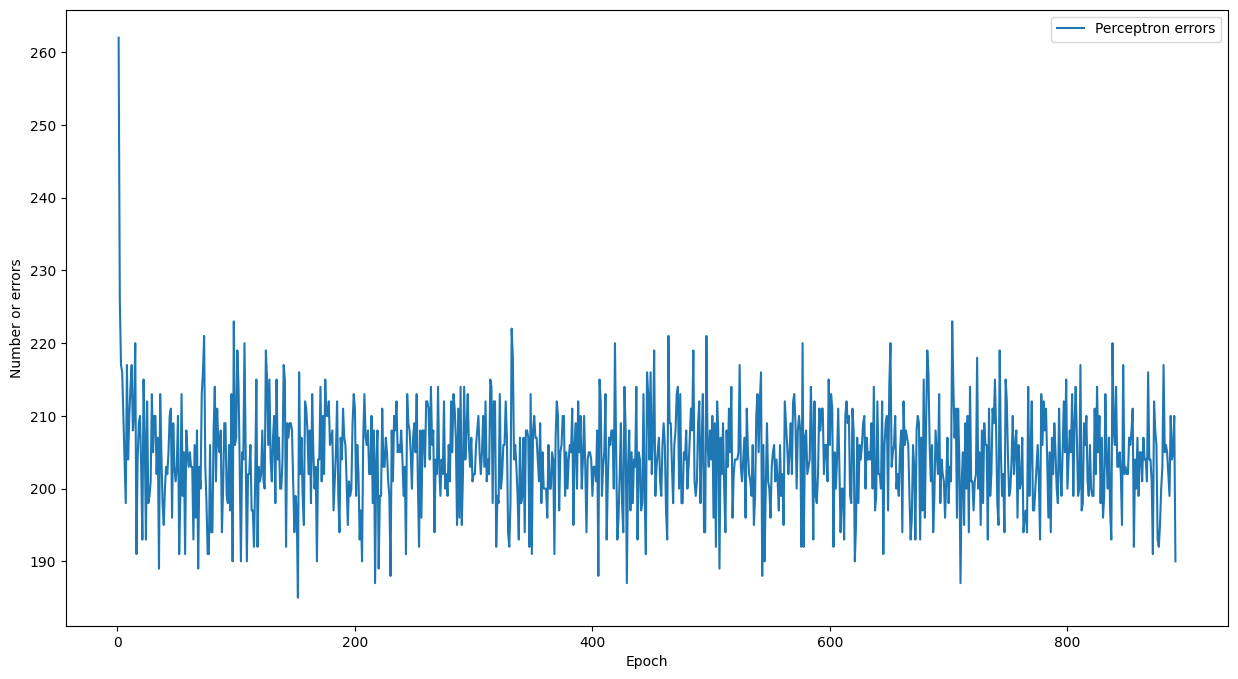

In [18]:
fig = plt.subplots(figsize=(15, 8))
plt.plot(range(1, len(Pc.errors_) + 1), Pc.errors_)

plt.legend(['Perceptron errors'], loc='upper right')
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Number or errors', fontsize=10)

plt.show()

In [21]:
class Adjusted_Perceptron:
    
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        cor_X = X.copy()
        cor_y = y.copy()
        cor_X['Target'] = cor_y
        self.w_ = [cor_X.corr()['Target'].values[i]
                  for i in range(len(cor_X.corr()['Target'].values))
                  if cor_X.corr()['Target'].index[i] != 'Target']
        self.w_.insert(0, 0)
        
        self.errors_ = []
        for _ in range(self.n_iter):
            errors = 0
            for i in range(len(X)):
                xi = X.iloc[i].values
                target = y[i]
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self
    
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

In [22]:
APc = Adjusted_Perceptron(n_iter=100)
APc.fit(train_X, train_y)

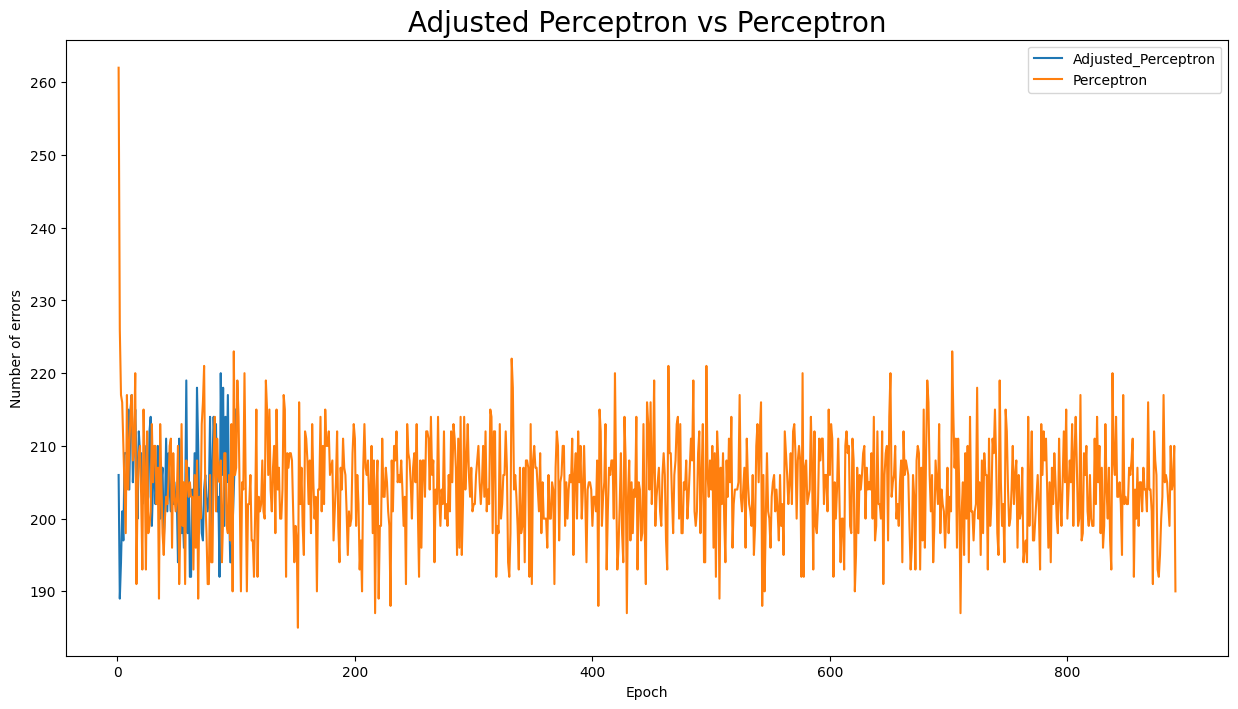

In [23]:
fig = plt.subplots(figsize = (15, 8))
plt.plot(range(1, len(APc.errors_) + 1), APc.errors_)
plt.plot(range(1, len(Pc.errors_) + 1), Pc.errors_)

plt.legend(['Adjusted_Perceptron', 'Perceptron'], loc = 'upper right')
plt.title('Adjusted Perceptron vs Perceptron', fontsize = 20)
plt.xlabel('Epoch', fontsize = 10)
plt.ylabel('Number of errors', fontsize = 10)

plt.show()


In [24]:
Pc = Perceptron(n_iter = 10)
Pc.fit(train_X, train_y)
predict = [Pc.predict(test_X)]
APc = Adjusted_Perceptron(n_iter = 2)
APc.fit(train_X, train_y)
predict.append(APc.predict(test_X))

for i in range(len(predict)):
    submission = pd.DataFrame(columns = ['PassengerId', 'Survived'])
    submission['PassengerId'] = df['PassengerId'][891:].map(int)
    submission['Survived'] = predict[i]
    submission.to_csv('Perceptron_submission_{}.csv'.format(i + 1), header = True, index = False)

In [64]:
train_X_np = np.array(train_X)
train_y_np = np.array(train_y)

In [78]:
class AdalineSGD:
    
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle=shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.errors_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.errors_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(x, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
    
    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

In [79]:
AdaSGD = AdalineSGD(n_iter=100)
AdaSGD.fit(train_X_np, train_y_np)

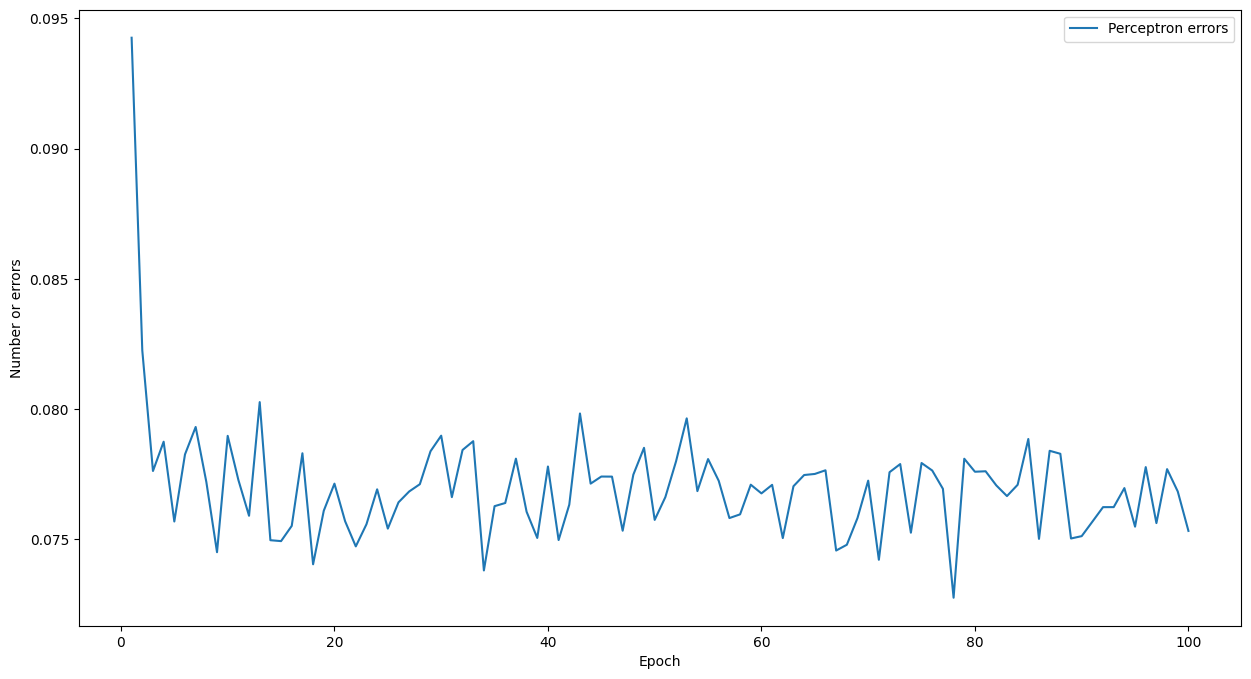

In [80]:
fig = plt.subplots(figsize=(15, 8))
plt.plot(range(1, len(AdaSGD.errors_) + 1), AdaSGD.errors_)

plt.legend(['Perceptron errors'], loc='upper right')
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Number or errors', fontsize=10)

plt.show()

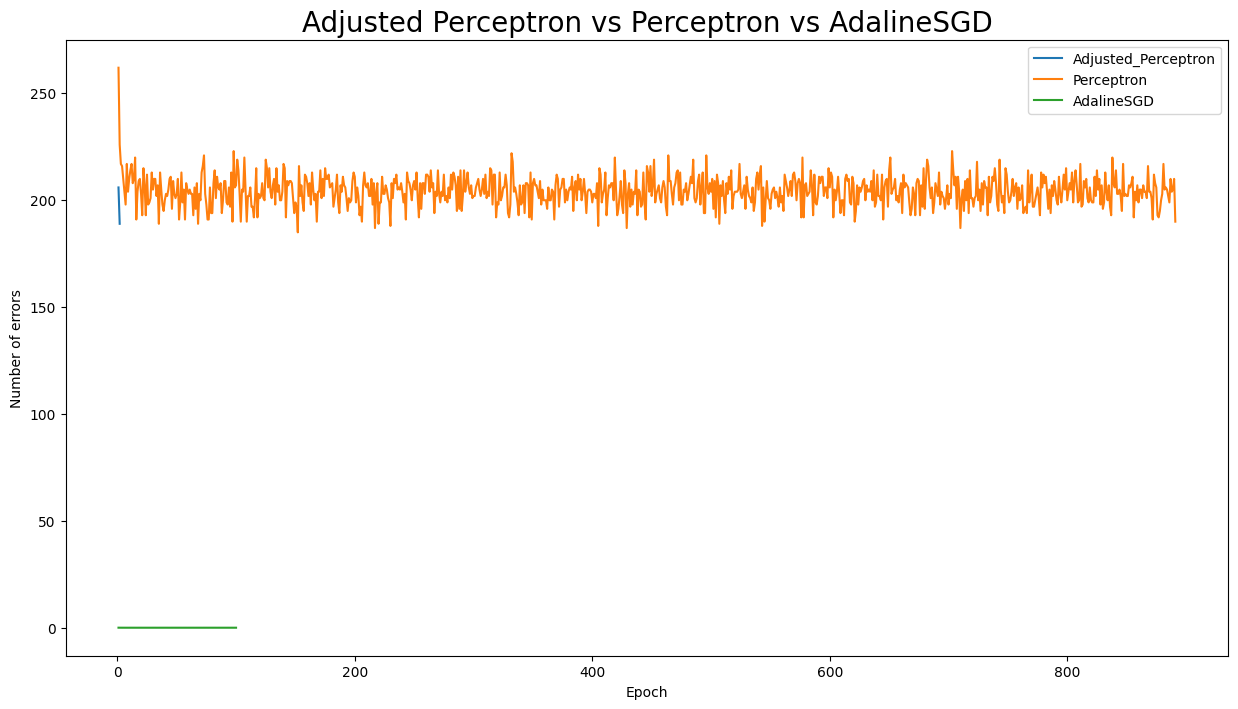

In [75]:
fig = plt.subplots(figsize = (15, 8))
plt.plot(range(1, len(APc.errors_) + 1), APc.errors_)
plt.plot(range(1, len(Pc.errors_) + 1), Pc.errors_)
plt.plot(range(1, len(AdaSGD.errors_) + 1), AdaSGD.errors_)

plt.legend(['Adjusted_Perceptron', 'Perceptron', 'AdalineSGD'], loc = 'upper right')
plt.title('Adjusted Perceptron vs Perceptron vs AdalineSGD', fontsize = 20)
plt.xlabel('Epoch', fontsize = 10)
plt.ylabel('Number of errors', fontsize = 10)

plt.show()


In [81]:
test_X_np = np.array(test_X)
predict = AdaSGD.predict(test_X_np)

In [82]:
submission = pd.DataFrame(columns = ['PassengerId', 'Survived'])
submission['PassengerId'] = df['PassengerId'][891:].map(int)
submission['Survived'] = predict
submission.to_csv('Perceptron_submission_{}.csv'.format(3), header = True, index = False)